## 数据集获取

Fashion-Mnist数据集的格式与Mnist数据集相同，为了更通用，我们采用从原始数据文件进行数据的读取，有关更多的数据读取方式可参见我之前发的[一篇博客](https://blog.csdn.net/qq_39567427/article/details/106305589)

你可以在[AIStudio数据集选项卡](https://aistudio.baidu.com/aistudio/datasetdetail/57449)下获取此数据集，或在[github仓库](https://github.com/zalandoresearch/fashion-mnist)获取此数据集

| 第一类 | 第二类 | 第三类 | 第四类 | 第五类 | 第六类 | 第七类 | 第八类 | 第九类 | 第十类 |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
| T-shirt/top（T恤） | Trouser（裤子）| Pullover（套衫）| Dress（裙子）| Coat（外套）| Sandal（凉鞋）| Shirt（汗衫）| Sneaker（运动鞋）| Bag（包）| Ankle boot（踝靴）|

## 导入必要的包

In [1]:
import paddle
import gzip
import math
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import paddle.nn.functional as F
import warnings
from paddle.io import Dataset
warnings.filterwarnings("ignore")

paddle.__version__

'2.0.0-rc1'

## 数据处理

定义数据解压函数

In [2]:
def extract_data(filename, num_data, head_size, data_size):
    with gzip.open(filename) as bytestream:
        bytestream.read(head_size)
        buf = bytestream.read(data_size * num_data)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float)
    return data

定义数据装载函数，其中`onehot`用于表示是否使用独热码生成标签

In [3]:
def load_data(dataset_name, onehot=False):
    data_dir = 'fashion_mnist'

    data = extract_data(data_dir + '/train-images-idx3-ubyte.gz', 60000, 16, 28 * 28)
    train_images = data.reshape((-1, 28, 28, 1))

    data = extract_data(data_dir + '/train-labels-idx1-ubyte.gz', 60000, 8, 1)
    train_labels = data.reshape((-1))

    data = extract_data(data_dir + '/t10k-images-idx3-ubyte.gz', 10000, 16, 28 * 28)
    test_images = data.reshape((-1, 28, 28, 1))

    data = extract_data(data_dir + '/t10k-labels-idx1-ubyte.gz', 10000, 8, 1)
    test_labels = data.reshape((-1))

    train_images = np.asarray(train_images)
    test_labels = np.asarray(test_labels)

    X = np.concatenate((train_images, test_images), axis=0)
    y = np.concatenate((train_labels, test_labels), axis=0).astype(np.int)
    
    if onehot== True:
        y_vec = np.zeros((len(y), 10), dtype=np.float)
        for i, label in enumerate(y):
            y_vec[i, y[i]] = 1.0
        
        return X, y_vec

    return X, y

读取数据

In [4]:
class_dict = {0:'T-shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
              5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

all_images, all_labels = load_data('fashion_mnist')

In [5]:
train_images, train_labels = all_images[:60000], all_labels[:60000]
val_images, val_labels = all_images[60000:], all_labels[60000:]

## 数据可视化

In [6]:
def plot_num_images(num):
    if num < 1:
        print('INFO:The number of input pictures must be greater than zero!')
    else:
        choose_list = []
        for i in range(num):
            choose_n = np.random.randint(len(train_images))
            choose_list.append(choose_n)
        fig = plt.gcf()
        fig.set_size_inches(18, 15)
        for i in range(num):
            ax_img = plt.subplot(math.ceil(num / 3), 8, i + 1)
            plt_img = train_images[choose_list[i]].reshape(28, 28)
            ax_img.imshow(plt_img, cmap='binary')
            ax_img.set_title(class_dict[train_labels[choose_list[i]]],
                             fontsize=10)
        plt.show()

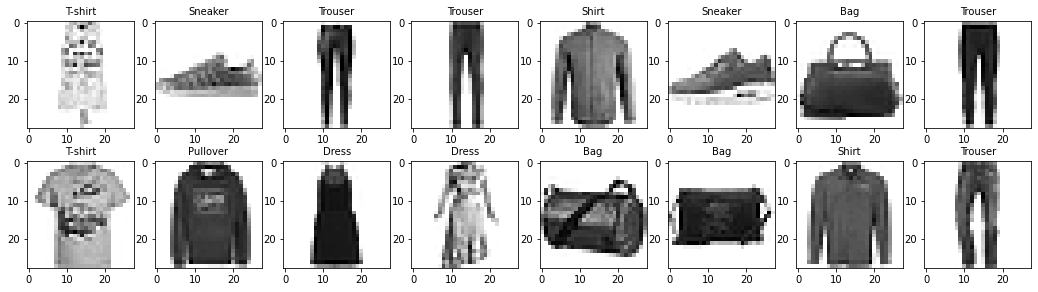

In [7]:
plot_num_images(16)

## 数据装载

定义`FashionDataset`数据类

In [8]:
class FashionDataset(Dataset):
    def __init__(self, mode='train'):
        super(FashionDataset, self).__init__()
        if mode == 'train':
            self.data = [[train_images[i].astype('float32').flatten(), train_labels[i].astype('int64')] for i in range(train_images.shape[0])]
        else:
            self.data = [[val_images[i].astype('float32').flatten(), val_labels[i].astype('int64')] for i in range(val_images.shape[0])]

    def __getitem__(self, index):
        data = self.data[index][0]
        label = self.data[index][1]

        return data, label

    def __len__(self):
        return len(self.data)

In [9]:
train_loader = paddle.io.DataLoader(FashionDataset(mode='train'), batch_size=10000, shuffle=True)
val_loader = paddle.io.DataLoader(FashionDataset(mode='val'), batch_size=10000, shuffle=True)

## 建模训练

这里我们选择Paddle高阶API进行建模训练

In [10]:
classification = paddle.nn.Sequential(
    paddle.nn.Linear(784, 256),
    paddle.nn.Linear(256, 10),
)

model = paddle.Model(classification)
model.summary((784))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Linear-1           [[784]]               [256]             200,960    
   Linear-2           [[256]]                [10]              2,570     
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.78
Estimated Total Size (MB): 0.78
---------------------------------------------------------------------------



{'total_params': 203530, 'trainable_params': 203530}

In [11]:
model.prepare(optimizer=paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters()),
              loss=paddle.nn.CrossEntropyLoss(),
              metrics=paddle.metric.Accuracy())
callback = paddle.callbacks.VisualDL(log_dir='log')

In [12]:
model.fit(train_loader,
          val_loader,
          epochs=50,
          batch_size=32,
          verbose=1,
          callbacks=callback)

The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/50
step 6/6 [==============================] - loss: 169.0003 - acc: 0.2945 - 650ms/step
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 1/1 [==============================] - loss: 126.2418 - acc: 0.4275 - 267ms/step
Eval samples: 10000
Epoch 2/50
step 6/6 [==============================] - loss: 60.4907 - acc: 0.5221 - 189ms/step
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 1/1 [==============================] - loss: 52.0316 - acc: 0.6389 - 176ms/step
Eval samples: 10000
Epoch 3/50
step 6/6 [==============================] - loss: 59.7795 - acc: 0.6465 - 169ms/step
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 1/1 [=========

Eval samples: 10000
Epoch 26/50
step 6/6 [==============================] - loss: 16.7368 - acc: 0.7631 - 170ms/step
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 1/1 [==============================] - loss: 17.2205 - acc: 0.7594 - 179ms/step
Eval samples: 10000
Epoch 27/50
step 6/6 [==============================] - loss: 12.6877 - acc: 0.8018 - 169ms/step
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 1/1 [==============================] - loss: 14.4492 - acc: 0.7895 - 171ms/step
Eval samples: 10000
Epoch 28/50
step 6/6 [==============================] - loss: 11.5339 - acc: 0.8017 - 168ms/step
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 1/1 [==============================] - loss: 13.0791 - acc: 0.7983 - 163ms/step
Eval samples: 10000
Ep

## 模型验证

In [13]:
model.evaluate(FashionDataset(mode='test'), batch_size=64, verbose=1)

Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 157/157 [==============================] - loss: 12.4378 - acc: 0.8024 - 3ms/step          
Eval samples: 10000


{'loss': [12.43781], 'acc': 0.8024}

获取在验证集上每一类的准确率

In [14]:
Correct_num = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
predict_onehot = model.predict(FashionDataset(mode='test'), batch_size=10000)
predict_result = np.argmax(predict_onehot[0][0], axis=1)
for i in range(len(val_labels)):
    if predict_result[i] == val_labels[i]:
        Correct_num[val_labels[i]] += 1
Correct_rate = {}
for key in Correct_num:
    Correct_rate[class_dict[key]] = Correct_num[key] / sum(val_labels==key)

Predict begin...
step 1/1 [==============================] - 118ms/step
Predict samples: 10000


In [15]:
Correct_rate

{'T-shirt': 0.65,
 'Trouser': 0.952,
 'Pullover': 0.72,
 'Dress': 0.747,
 'Coat': 0.774,
 'Sandal': 0.898,
 'Shirt': 0.58,
 'Sneaker': 0.884,
 'Bag': 0.887,
 'Ankle boot': 0.932}

通过柱状图更直观的可视化每一类正确率

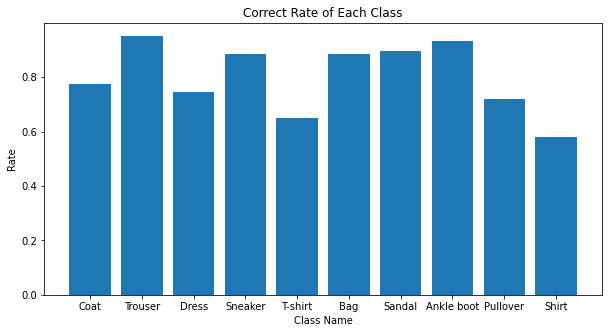

In [16]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
class_name = {'T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal','Shirt', 'Sneaker', 'Bag', 'Ankle boot'}
plt.bar(range(10), [Correct_rate.get(class_name, 0) for class_name in class_name], align='center',yerr=0.000001)

plt.xticks(range(10), class_name)
plt.xlabel('Class Name')
plt.ylabel('Rate')
plt.title('Correct Rate of Each Class')
plt.show()

## VIsualDL可视化

使用`visualdl --logdir log`查看训练日志

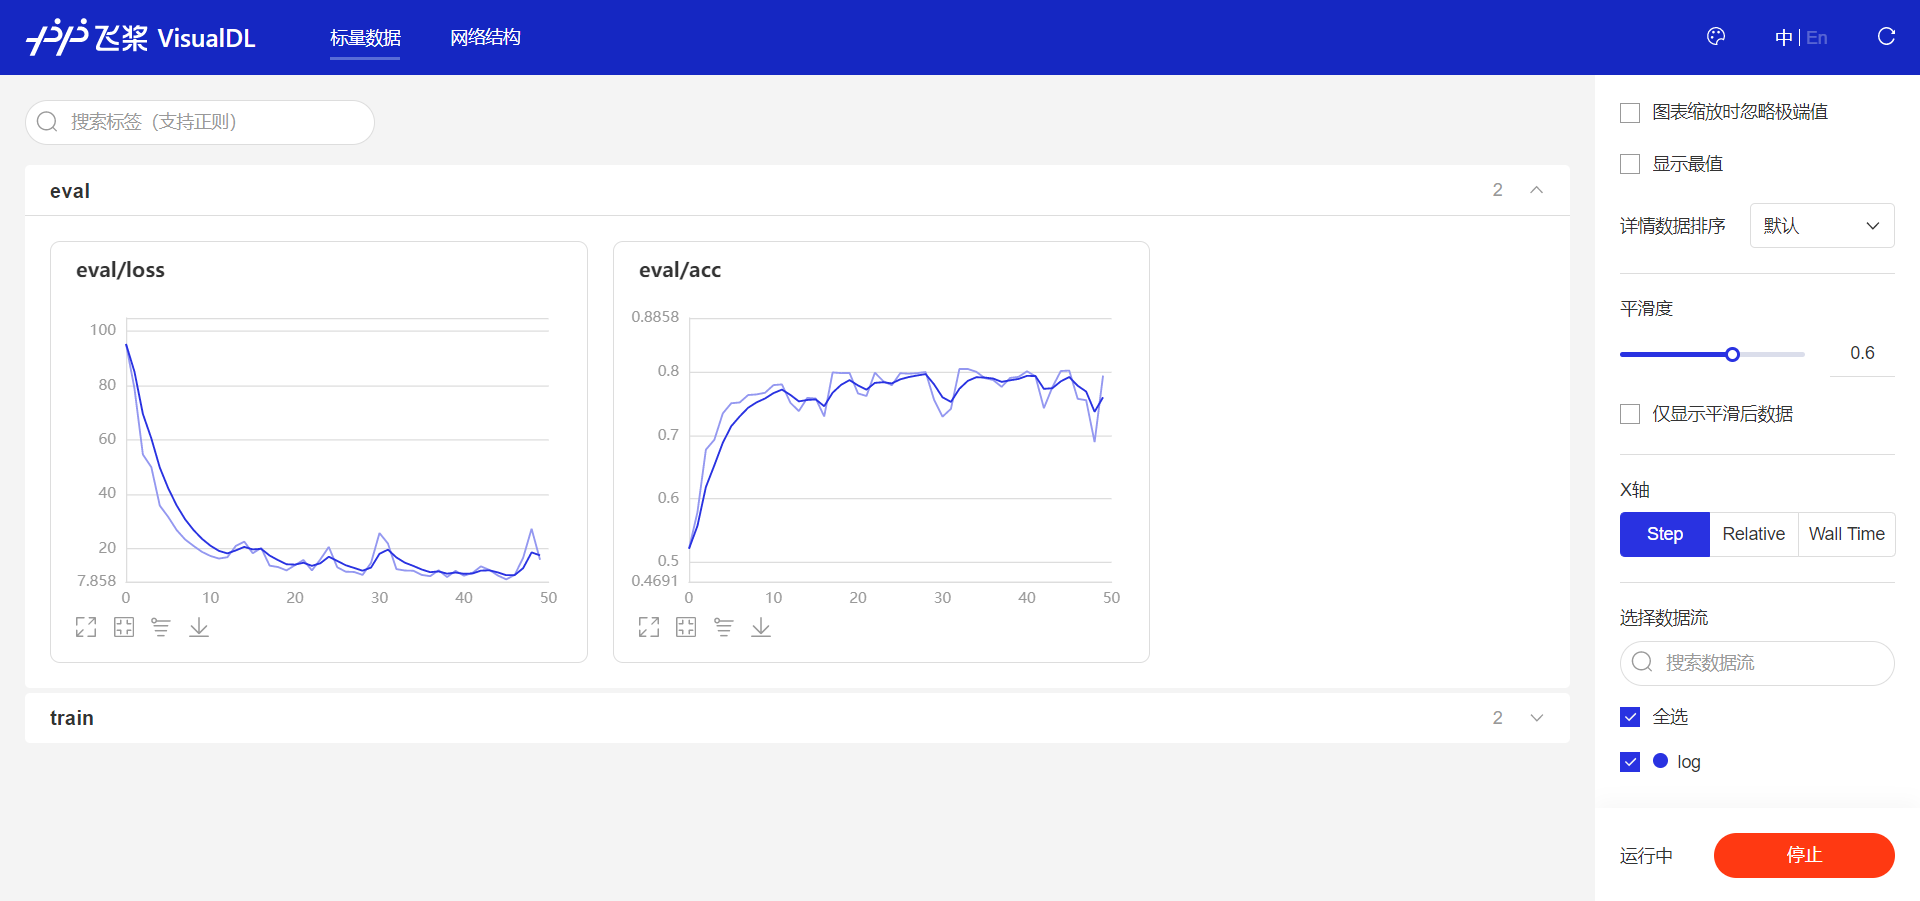